In [ ]:
import pathlib
import glob
import os
import json

import sys
import glob
from pathlib import Path, PurePath
path = Path.cwd()
parent_path = path.parents[1]
sys.path.append(str(PurePath(parent_path, 'neuroformer')))
sys.path.append('neuroformer')
sys.path.append('.')
sys.path.append('../')

import pandas as pd
import numpy as np

import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt

from torch.utils.data.dataloader import DataLoader

import math

from neuroformer.model_neuroformer import GPT, GPTConfig
from neuroformer.trainer import Trainer, TrainerConfig
from neuroformer.utils import set_seed, update_object, check_common_attrs, running_jupyter
from neuroformer.visualize import set_plot_params
from neuroformer.SpikeVidUtils import make_intervals, round_n, tokenizer, SpikeTimeVidData2
import gdown

parent_path = os.path.dirname(os.path.dirname(os.getcwd())) + "/"

import argparse
from neuroformer.SpikeVidUtils import round_n

# set up logging
import logging
logging.basicConfig(
        format="%(asctime)s - %(levelname)s - %(name)s -   %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S",
        level=logging.INFO,
)

def parse_args():
    parser = argparse.ArgumentParser()
    # parser.add_argument("--infer", action="store_true", help="Inference mode")
    parser.add_argument("--train", action="store_true", default=False, help="Train mode")
    parser.add_argument("--dist", action="store_true", default=False, help="Distributed mode")
    parser.add_argument("--seed", type=int, default=25, help="Random seed")
    parser.add_argument("--resume", type=str, default=None, help="Resume from checkpoint")
    parser.add_argument("--rand_perm", action="store_true", default=False, help="Randomly permute the ID column")
    parser.add_argument("--mconf", type=str, default=None, help="Path to model config file")
    parser.add_argument("--eos_loss", action="store_true", default=False, help="Use EOS loss")
    parser.add_argument("--no_eos_dt", action="store_true", default=False, help="No EOS dt token")
    parser.add_argument("--downstream", action="store_true", default=False, help="Downstream task")
    parser.add_argument("--freeze_model", action="store_true", default=False, help="Freeze model")
    parser.add_argument("--title", type=str, default=None)
    parser.add_argument("--dataset", type=str, default="Combo3_SimNeu3D")
    parser.add_argument("--behavior", action="store_true", default=False, help="Behavior task")
    parser.add_argument("--pred_behavior", action="store_true", default=False, help="Predict behavior")
    parser.add_argument("--past_state", action="store_true", default=False, help="Input past state")
    parser.add_argument("--visual", action="store_true", default=False, help="Visualize")
    parser.add_argument("--contrastive", action="store_true", default=False, help="Contrastive")
    parser.add_argument("--clip_loss", action="store_true", default=False, help="Clip loss")
    parser.add_argument("--clip_vars", nargs="+", default=['id','frames'], help="Clip variables")
    parser.add_argument("--class_weights", action="store_true", default=False, help="Class weights")
    parser.add_argument("--resample", action="store_true", default=False, help="Resample")
    return parser.parse_args()

print(f"running_jupyter: {running_jupyter()}")
# if running_jupyter(): # or __name__ == "__main__":
print("Running in Jupyter")
INFERENCE = True
DIST = False
SEED = 25
DOWNSTREAM = False
TITLE = None
RESUME = "./models/tensorboard/Combo3_SimNeu3D/first/f_window_0.5/sparse_f:None_id:None/w:0.1_wp:0.1/Cont:False['id', 'frames']_window:0.1_f_window:1_df:0.01_blocksize:20_conv_True_shuffle:True_batch:512_sparse_(None_None)_blocksz40_pos_emb:False_temp_emb:True_drop:0.35_dt:True_2.0_12_max0.01_(4, 0, 4)_4_256.pt"
RAND_PERM = False
MCONF = None
EOS_LOSS = False
NO_EOS_DT = False
FREEZE_MODEL = False
TITLE = None
DATASET = "Combo3_SimNeu3D"
BEHAVIOR = False
PREDICT_BEHAVIOR = False
VISUAL = True
PAST_STATE = True
CONTRASTIVE = False
CLIP_LOSS = True
CLIP_VARS = ['id','frames']
CLASS_WEIGHTS = False
RESAMPLE_DATA = False
# else:
#     print("Running in terminal")
#     args = parse_args()
#     INFERENCE = not args.train
#     DIST = args.dist
#     SEED = args.seed
#     DOWNSTREAM = args.downstream
#     TITLE = args.title
#     RESUME = args.resume
#     RAND_PERM = args.rand_perm
#     MCONF = args.mconf
#     EOS_LOSS = args.eos_loss
#     NO_EOS_DT = args.no_eos_dt
#     FREEZE_MODEL = args.freeze_model
#     DATASET = args.dataset
#     BEHAVIOR = args.behavior
#     PREDICT_BEHAVIOR = args.pred_behavior
#     VISUAL = args.visual
#     PAST_STATE = args.past_state
#     CONTRASTIVE = args.contrastive
#     CLIP_LOSS = args.clip_loss
#     CLIP_VARS = args.clip_vars
#     CLASS_WEIGHTS = args.class_weights
#     RESAMPLE_DATA = args.resample

# SET SEED - VERY IMPORTANT
set_seed(SEED)

print(f"CONTRASTIUVEEEEEEE {CONTRASTIVE}")
print(f"VISUAL: {VISUAL}")
print(f"PAST_STATE: {PAST_STATE}")


os.environ['CUDA_VISIBLE_DEVICES'] = '3'


In [ ]:
""" 

-- DATA --
neuroformer/data/OneCombo3_V1AL/
df = response
video_stack = stimulus
DOWNLOAD DATA URL = https://drive.google.com/drive/folders/1jNvA4f-epdpRmeG9s2E-2Sfo-pwYbjeY?usp=sharing


"""

from neuroformer.prepare_data import DataLinks

ds = DATASET

DATA_POINTERS = getattr(DataLinks, ds)
DATA_DIR = DATA_POINTERS['DIRECTORY']
RESPONSE_PATH = DATA_POINTERS['RESPONSE_PATH']
STIMULUS_PATH = DATA_POINTERS['STIMULUS_PATH']
data_dir = f"./data/{ds}/"

if not os.path.exists(DATA_DIR):
    print("Downloading data...")
    import gdown
    url = DATA_POINTERS['url']
    gdown.download_folder(id=url, quiet=False, use_cookies=False, output=DATA_POINTERS['DIRECTORY'])


df = pd.read_csv(RESPONSE_PATH)
video_stack = torch.load(STIMULUS_PATH)
stimulus = video_stack[0, :, 0]

print(f"VIDEO STACK SHAPE: {video_stack.shape}")
print(f"STIMULUS SHAPE: {stimulus.shape}")



In [ ]:
# load config files
import yaml

# base_path = "configs/visnav/predict_behavior"
if MCONF is not None:
    base_path = os.path.dirname(MCONF)
elif RESUME is not None:
    base_path = os.path.dirname(RESUME)
else:
    base_path = "./configs/Combo3_V1AL/kernel_size/wave_emb/01second-noselfatt/01second-noselfatt_small/"
    

with open(os.path.join(base_path, 'mconf.yaml'), 'r') as stream:
    mconf = yaml.full_load(stream)

with open(os.path.join(base_path, 'tconf.yaml'), 'r') as stream:
    tconf = yaml.full_load(stream)

with open(os.path.join(base_path, 'dconf.yaml'), 'r') as stream:
    dconf = yaml.full_load(stream)

import omegaconf
from omegaconf import OmegaConf

# open yaml as omegacong
mconf = OmegaConf.create(mconf)
tconf = OmegaConf.create(tconf)
dconf = OmegaConf.create(dconf)

# set attrs that are not equal
common_attrs = check_common_attrs(mconf, tconf, dconf)
print(f"Common attributes: {common_attrs}")





In [ ]:

if INFERENCE or mconf:
    frame_window = mconf.frame_window
    window = mconf.window
    window_prev = mconf.window_prev
    window_behavior = mconf.window_behavior if hasattr(mconf, 'window_behavior') else None
    dt = mconf.dt
    dt_frames = mconf.dt_frames if hasattr(mconf, 'dt_frames') else 0.05
    dt_vars = mconf.dt_vars if hasattr(mconf, 'dt_vars') else 0.05
    dt_speed = mconf.dt_speed if hasattr(mconf, 'dt_speed') else 0.2
    intervals = None
else:
    frame_window = 0.5
    window = 0.05
    window_prev = None
    window_behavior = window
    dt = 0.01
    dt_frames = 0.05
    dt_vars = 0.05
    dt_speed = 0.2
    intervals = None

# randomly permute 'id' column
if RAND_PERM:
    df['ID'] = df['ID'].sample(frac=1, random_state=25).reset_index(drop=True)


In [ ]:
## choose modalities ##

# behavior
behavior = BEHAVIOR
behavior_vars = ['eyerad', 'phi', 'speed', 'th']
# behavior_vars = ['speed']
n_behavior = len(behavior_vars)
predict_behavior = PREDICT_BEHAVIOR
# stimulus
visual_stim = VISUAL







In [ ]:
from neuroformer.SpikeVidUtils import trial_df, get_df_visnav, make_intervals


if behavior is True:
    behavior = pd.DataFrame({k: data[k] for k in behavior_vars + ['t']})
    # rename t to time
    behavior = behavior.rename(columns={'t': 'Time'}) if behavior is not None else None
    behavior['Interval'] = make_intervals(behavior, window)
    behavior['Interval_2'] = make_intervals(behavior, window_prev)

    # prepare speed variables
    behavior['speed'] = behavior['speed'].apply(lambda x: round_n(x, dt_speed))
    dt_range_speed = behavior['speed'].min(), behavior['speed'].max()
    dt_range_speed = np.arange(dt_range_speed[0], dt_range_speed[1] + dt_speed, dt_speed)
    n_behavior = len(dt_range_speed)

    stoi_speed = { round_n(ch, dt_speed):i for i,ch in enumerate(dt_range_speed) }
    itos_speed = { i:round_n(ch, dt_speed) for i,ch in enumerate(dt_range_speed) }
    assert (window_behavior) % dt_vars < 1e-5, "window + window_prev must be divisible by dt_vars"
    samples_per_behavior = int((window + window_prev) // dt_vars)
    behavior_block_size = int((window + window_prev) // dt_vars) * (len(behavior.columns) - 1)
else:
    behavior = None
    behavior_vars = None
    behavior_block_size = 0
    samples_per_behavior = 0
    stoi_speed = None
    itos_speed = None
    dt_range_speed = None
    n_behavior = None

if predict_behavior:
    loss_bprop = ['behavior']
else:
    loss_bprop = None








In [ ]:

df['Interval'] = make_intervals(df, window)
df['real_interval'] = make_intervals(df, 0.05)
df['Interval_2'] = make_intervals(df, window_prev)
df = df.reset_index(drop=True)

# randomly permute 'id' column
if RAND_PERM:
    print('// randomly permuting ID column //')
    df['ID'] = df['ID'].sample(frac=1, random_state=25).reset_index(drop=True)




In [ ]:
## resnet3d feats
n_frames = round(frame_window * 1/dt_frames)
# kernel_size = (n_frames, 4, 4)
kernel_size = [n_frames, 8, 8]
stride_size = [n_frames, 4, 4]
padding_size = 0
n_embd = 256
n_embd_frames = 64
frame_feats = stimulus
frame_block_size = 0
frame_feats = torch.tensor(stimulus, dtype=torch.float32)
conv_layer = True

prev_id_block_size = 20
id_block_size = 20   #
block_size = frame_block_size + id_block_size + prev_id_block_size
frame_memory = frame_window // dt_frames
window = window

neurons = sorted(list(set(df['ID'])))
max_window = max(window, window_prev)
stoi, itos, stoi_dt, itos_dt = tokenizer(neurons, max_window, dt, NO_EOS_DT)




In [ ]:
# # %%
# var_group = 'Interval'
# int_trials = df.groupby([var_group, 'Trial']).size()
# print(int_trials.mean())
# # df.groupby(['Interval', 'Trial']).agg(['nunique'])
# n_unique = len(df.groupby([var_group, 'Trial']).size())
# df.groupby([var_group, 'Trial']).size().nlargest(int(0.1 * n_unique))
# # df.groupby(['Interval_2', 'Trial']).size().mean()




In [ ]:
import random

r_split = 0.8
all_trials = sorted(df['Trial'].unique())
train_trials = random.sample(all_trials, int(len(all_trials) * r_split))

train_data = df[df['Trial'].isin(train_trials)]
test_data = df[~df['Trial'].isin(train_trials)]

# r_split_ft = np.arange(0, 1, 0.25)
r_split_ft = 0.1
finetune_trials = train_trials[:int(len(train_trials) * r_split_ft)]
finetune_data = df[df['Trial'].isin(finetune_trials)]

n = []
n_trial = [2, 8, 14, 19]
for n_stim in range(df['Trial'].max() // 20):
    # n_trial = [2, 4, 6, 8, 10, 12, 14, 18]
    for n_t in n_trial:
        trial = (n_stim + 1) * 20 - (n_t)
        n.append(trial)
train_data = df[~df['Trial'].isin(n)].reset_index(drop=True)
test_data = df[df['Trial'].isin(n)].reset_index(drop=True)
small_data = df[df['Trial'].isin([5])].reset_index(drop=True)



In [ ]:
if CLASS_WEIGHTS:
    class_weights = {}
    class_weights['id'] = torch.ones(len(stoi.keys()), dtype=torch.float32)
    class_weights['id'][stoi['PAD']] = 0
    class_weights['id'][stoi['EOS']] = 1 / 10
    class_weights['dt'] = torch.ones(len(stoi_dt.keys()), dtype=torch.float32)
    class_weights['dt'][stoi_dt['PAD']] = 0
else:
    class_weights = None



In [ ]:
from neuroformer.SpikeVidUtils import SpikeTimeVidData2

train_dataset = SpikeTimeVidData2(train_data, None, block_size, id_block_size, frame_block_size, prev_id_block_size, 
                                  window, dt, frame_memory, stoi, itos, neurons, stoi_dt, itos_dt, frame_feats,
                                  pred=False, window_prev=window_prev, frame_window=frame_window,
                                  dt_frames=dt_frames, intervals=None, dataset=DATASET,
                                  behavior=behavior, behavior_vars=behavior_vars, dt_vars=dt_vars,
                                  behavior_block_size=behavior_block_size, samples_per_behavior=samples_per_behavior,
                                  window_behavior=window_behavior, predict_behavior=predict_behavior,
                                  stoi_speed=stoi_speed, itos_speed=itos_speed, dt_speed=dt_speed, labels=True,
                                  resample_data=RESAMPLE_DATA)

# update_object(train_dataset, dconf)
train_dataset = train_dataset.copy(train_data)
test_dataset = train_dataset.copy(test_data, resample_data=False)
finetune_dataset = train_dataset.copy(finetune_data, resample_data=False)
    
print(f'train: {len(train_dataset)}, test: {len(test_dataset)}')



In [ ]:

layers = (mconf.n_state_layers, mconf.n_state_history_layers, mconf.n_stimulus_layers)   
max_epochs = 1000
batch_size = round((32 * 16))
shuffle = True

model_conf = GPTConfig(train_dataset.population_size, block_size,    # frame_block_size
                        id_vocab_size=train_dataset.id_population_size,
                        frame_block_size=frame_block_size,
                        id_block_size=id_block_size,  # frame_block_size
                        prev_id_block_size=prev_id_block_size,
                        behavior_block_size=behavior_block_size,
                        sparse_mask=False, p_sparse=None, 
                        sparse_topk_frame=None, sparse_topk_id=None, sparse_topk_prev_id=None,
                        n_dt=len(stoi_dt.keys()),
                        pretrain=False,
                        n_state_layers=4, n_state_history_layers=0,
                        n_stimulus_layers=4, self_att_layers=0,
                        n_behavior_layers=0, predict_behavior=predict_behavior, n_behavior=n_behavior,
                        n_head=4, n_embd=n_embd, 
                        contrastive=mconf.contrastive, clip_emb=1024, clip_temp=mconf.clip_temp,
                        conv_layer=conv_layer, kernel_size=kernel_size, stride_size=stride_size, padding_size=padding_size,
                        temp_emb=mconf.temp_emb, pos_emb=False,
                        id_drop=0.35, im_drop=0.35, b_drop=0.45,
                        window=window, window_prev=window_prev, frame_window=frame_window, dt=dt,
                        neurons=neurons, stoi_dt=stoi_dt, itos_dt=itos_dt, n_embd_frames=n_embd_frames,
                        ignore_index_id=stoi['PAD'], ignore_index_dt=stoi_dt['PAD'],
                        eos_loss=EOS_LOSS,
                        class_weights=class_weights, contrastive_vars=CLIP_VARS)  # 0.35

if INFERENCE or MCONF is not None:
    update_object(model_conf, mconf)

if not INFERENCE:
    if PAST_STATE is False:
        print(f"// -- No past state, layers=0 -- //")
        model_conf.n_state_history_layers = 0

    if CONTRASTIVE or CLIP_LOSS is True:
        print(f"// -- contrastive objective clip{CLIP_LOSS} -- //")
        model_conf.contrastive = True
        model_conf.clip_loss = CLIP_LOSS
    else:
        print(f"// -- no contrastive objective -- //")
        model_conf.contrastive = False
    if VISUAL is False:
        print(f"// -- No visual, layers=0 -- //")
        model_conf.n_stimulus_layers = 0

model = GPT(model_conf)



In [ ]:
loader = DataLoader(train_dataset, batch_size=2, shuffle=False, num_workers=4, pin_memory=True)
iterable = iter(loader)




In [ ]:
train_dataset.frame_feats.shape



In [ ]:
x, y = next(iterable)
# print(x['behavior'].shape, x['behavior_dt'].shape)
for k in x.keys():
    print(k, x[k].shape)
for k in y.keys():
    print(f"y: {k}, {y[k].shape}")


# epoch250_rand{RAND_PERM}_downstream:{DOWNSTREAM}
# title =  f'3/4prop_{CLASS_WEIGHTS}/past_state_{PAST_STATE}_visual{VISUAL}_contrastive_{CONTRASTIVE}_clip_loss{CLIP_LOSS}t{mconf.clip_temp}_freeze_{FREEZE_MODEL}_class_weights{CLASS_WEIGHTS}/randperm_{RAND_PERM}/Big_fixed_noself-att'
# title = f'ablations_2/{SEED}/RESUME{RESUME != None}_paststate{PAST_STATE}_visual{VISUAL}_contrastive{model_conf.contrastive}'
# model_path = f"""./models/tensorboard/{DATASET}/ablations_small/{title}_2/sparse_f:{mconf.sparse_topk_frame}_id:{mconf.sparse_topk_id}/w:{mconf.window}_wp:{mconf.window_prev}/Cont:{mconf.contrastive}_window:{mconf.window}_f_window:{mconf.frame_window}_df:{mconf.dt}_blocksize:{mconf.id_block_size}_conv_{mconf.conv_layer}_shuffle:{shuffle}_batch:{batch_size}_sparse_({mconf.sparse_topk_frame}_{mconf.sparse_topk_id})_blocksz{block_size}_pos_emb:{mconf.pos_emb}_temp_emb:{mconf.temp_emb}_drop:{mconf.id_drop}_dt:{shuffle}_2.0_{max(stoi_dt.values())}_max{dt}_{layers}_{mconf.n_head}_{mconf.n_embd}.pt"""
model_path = f"""./models/tensorboard/{DATASET}/{TITLE}/sparse_f:{mconf.sparse_topk_frame}_id:{mconf.sparse_topk_id}/w:{mconf.window}_wp:{mconf.window_prev}/Cont:{mconf.contrastive}{CLIP_VARS}_window:{mconf.window}_f_window:{mconf.frame_window}_df:{mconf.dt}_blocksize:{mconf.id_block_size}_conv_{mconf.conv_layer}_shuffle:{shuffle}_batch:{batch_size}_sparse_({mconf.sparse_topk_frame}_{mconf.sparse_topk_id})_blocksz{block_size}_pos_emb:{mconf.pos_emb}_temp_emb:{mconf.temp_emb}_drop:{mconf.id_drop}_dt:{shuffle}_2.0_{max(stoi_dt.values())}_max{dt}_{layers}_{mconf.n_head}_{mconf.n_embd}.pt"""
# model_path = RESUME






In [ ]:

if DOWNSTREAM:
    print(f"// Downstream Objective: {DOWNSTREAM} //")
    """
    image indexes

    (140, 260)
    (339, 424)
    (500, 620)
    (680, 840) 
    (960, 1050)

    """
    import tifffile
    from neuroformer.SpikeVidUtils import get_interval_idx
    from neuroformer.modules import ClassifierWrapper

    stim2_path = "./data/Combo3_V1AL/stimuli/Combined Stimuli 3-Movie2.tif"
    stimulus_2 = tifffile.imread(stim2_path)

    stim3_path = "./data/Combo3_V1AL/stimuli/Combined Stimuli 3-Movie3.tif"
    stimulus_3 = tifffile.imread(stim3_path)

    mouse_indexes = [(140, 260), (339, 424), (500, 620), (680, 840), (960, 1050)]
    stimulus_mice = np.concatenate([stimulus_2[i[0]:i[1]] for i in mouse_indexes])
    stimulus_control = np.concatenate([stimulus_3[i[0]:i[1]] for i in mouse_indexes])
    assert stimulus_mice.shape == stimulus_control.shape, "stimulus shapes must be equal"

    control_labels = np.zeros(stimulus_control.shape[0])
    mice_labels = np.ones(stimulus_mice.shape[0])
    stimulus_task = np.concatenate([stimulus_control, stimulus_mice])
    labels_task = np.concatenate([control_labels, mice_labels])
    mouse_indexes_downsampled = [tuple(map(lambda x: x // 3, i)) for i in mouse_indexes]
    stim_2_ds = stimulus[1]
    stim_2_ds_mice = np.concatenate([stim_2_ds[i[0]:i[1]] for i in mouse_indexes_downsampled])
    mouse_indexes_intervals = [tuple(map(lambda x: get_interval_idx(x, 0.05), i)) for i in mouse_indexes_downsampled]
    intervals_cls = np.concatenate([np.arange(i[0], i[1], window) for i in mouse_indexes_intervals])
    # don't use same intervals for training and testing (because images will be the same)
    train_interval_cls = np.random.choice(intervals_cls, size=int(len(intervals_cls) * 0.8), replace=False)
    test_interval_cls = np.setdiff1d(intervals_cls, train_interval_cls)
    train_trial_cls = train_data[train_data['Trial'] > 20]['Trial'].unique()
    test_trial_cls = test_data[test_data['Trial'] > 20]['Trial'].unique()
    train_interval_trial_cls = np.array(np.meshgrid(train_interval_cls, train_trial_cls)).T.reshape(-1, 2)
    test_interval_trial_cls = np.array(np.meshgrid(test_interval_cls, test_trial_cls)).T.reshape(-1, 2)
    train_dataset = train_dataset.copy(train_data, t=train_interval_trial_cls)
    test_dataset = test_dataset.copy(test_data, t=test_interval_trial_cls)


print(f"MODEL_PATH ---->: {model_path}")

In [ ]:
tconf = TrainerConfig(max_epochs=max_epochs, batch_size=batch_size, learning_rate=1e-4, 
                    num_workers=4, lr_decay=True, patience=3, warmup_tokens=8e4, 
                    decay_weights=True, weight_decay=0.1, shuffle=shuffle,
                    final_tokens=len(train_dataset)*(id_block_size) * (max_epochs),
                    clip_norm=1.0, grad_norm_clip=1.0,
                    dataset='Combo3_V1AL', mode='predict',
                    block_size=train_dataset.block_size,
                    id_block_size=train_dataset.id_block_size,
                    show_grads=False, plot_raster=False,
                    ckpt_path=model_path, no_pbar=False, 
                    dist=DIST, save_every=20, loss_bprop=loss_bprop)

if not INFERENCE:
    if DOWNSTREAM:
        mconf.__setattr__('freeze_model', FREEZE_MODEL)
        tconf.__setattr__('warmup_tokens', 100)
        N_CLASSES = 2
        classifier = ClassifierWrapper(model, mconf, N_CLASSES)
        train_model = classifier

    else:
        train_model = model
    trainer = Trainer(train_model, train_dataset, test_dataset, tconf, model_conf)
    trainer.train()
else:
    if RESUME is not None:
        model_path = RESUME
    else:
        model_path = glob.glob(os.path.join(base_path, '**.pt'), recursive=True)[0]
    print(f"Loading model from {model_path}")
    model.load_state_dict(torch.load(model_path, map_location='cpu'), strict=False)





In [ ]:
# model.eval()
# # model.train()
# for i in range(1):
#     x, y = next(iterable)
#     x_1 = x['id'][0].detach().cpu().numpy()
#     x_pad = x['pad']
#     x_1 = x['id'][:len(x_1) - int(x_pad[0])]
#     preds, features, loss = model(x, y)

#     step_choices = random.sample(range(len(x_1)), min(5, len(x_1)))
#     fig, ax = plt.subplots(1, len(step_choices), figsize=(50, 5))
#     for step in step_choices:
#         step_preds = preds['id'][0, step].detach().cpu().numpy()
#         x_axis = np.arange(0, len(step_preds))
#         ax_step = ax[step]
#         ax_step.scatter(x_axis, step_preds)
#         ax_step.set_title(f"""{step}""", fontsize=20)


In [ ]:
x, y = next(iterable)
for k in x.keys():
    print(k, x[k].shape)


In [ ]:
preds, features, loss = model(x, y)


In [ ]:
for key in features.keys():
    print(key, features[key].shape)


In [ ]:
from neuroformer.attentionVis import reshape_features

frame_att = reshape_features(features, kernel_size, frame_window, dt_frames)


In [ ]:
feats = features['raw_frames']
feats_frames = features['frames']
print(feats.shape)
print(feats_frames.shape)

feats_frames = feats_frames[:, 1:].detach().cpu().numpy()
feats_frames = feats_frames.reshape(-1, 15, 27, 256)
print(feats_frames.shape)

feats_un = torch.tensor(feats_frames)

torch.stack([feats_un, feats_un], dim=1).shape


In [ ]:
def register_attention_hooks(model):
    features = {}

    # helper function for hook
    def get_features(name):
        def hook(model, input, output):
            features[name] = output.detach().cpu()
        return hook

    grads = {}
    def get_grads(name):
        def hook(model, input, output):
            grads[name] = output.detach().cpu()
        return hook

    """
    register forward hooks for all multimodal transformer layers
    so that the features are saved after every forward pass
    """

    for n, mod in enumerate(model.neural_visual_transformer.neural_state_blocks):
        mod.register_forward_hook(get_features(f'neural_state_block_{n}'))

    for n, mod in enumerate(model.neural_visual_transformer.neural_state_history_blocks):
        mod.register_forward_hook(get_features(f'neural_state_history_block_{n}'))

    for n, mod in enumerate(model.neural_visual_transformer.neural_state_history_self_attention):
        mod.register_forward_hook(get_features(f'neural_state_history_self_attention_{n}'))

    for n, mod in enumerate(model.neural_visual_transformer.neural_state_stimulus_blocks):
        mod.register_forward_hook(get_features(f'neural_state_stimulus_block_{n}'))

    for n, mod in enumerate(model.neural_visual_transformer.neural_state_stimulus_blocks):
        mod.attn.attn_drop.register_full_backward_hook(get_grads(f'neural_state_stimulus_block_{n}'))

def get_atts(model):
    attentions = {}

    for n, mod in enumerate(model.neural_visual_transformer.neural_state_blocks):
        attentions[f'neural_state_block_{n}'] = mod.attn.att.detach().cpu()

    for n, mod in enumerate(model.neural_visual_transformer.neural_state_history_blocks):
        attentions[f'neural_state_history_block_{n}'] = mod.attn.att.detach().cpu()

    for n, mod in enumerate(model.neural_visual_transformer.neural_state_stimulus_blocks):
        attentions[f'neural_stimulus_block_{n}'] = mod.attn.att.detach().cpu()
    
    return attentions

def get_grads(model):
    grads = {}
    
    for n, mod in enumerate(model.neural_visual_transformer.neural_state_stimulus_blocks):
        grads[f'neural_stimulus_block_{n}'] = mod.attn.att.detach().cpu()    
    return grads

def gradcam(atts, grads):
    common_keys = set(atts.keys()).intersection(set(grads.keys()))
    for key in common_keys:
        atts[key] = atts[key] * grads[key]
    return atts

def accum_atts(att_dict, key=None):
    if key is None:
        att_keys = att_dict.keys()
    else:
        att_keys = [k for k in att_dict.keys() if key in k]
    atts = []
    for k in att_keys:
        att = att_dict[k]
        att = att.sum(-3).detach().cpu()
        reshape_c = att.shape[-1] // stimulus.shape[0]
        assert att.shape[-1] % stimulus.shape[0] == 0, "Attention shape does not match stimulus shape"
        att = att.view(att.shape[0], att.shape[-2], reshape_c, att.shape[-1] // reshape_c)
        att = att.sum(-2)
        atts.append(att)
    return torch.stack(atts)

def accum_atts_visual(att_dict, key='neural_stimulus_block'):
    """
    Accumulates attention weights for visual attention
    """
    if key is None:
        att_keys = att_dict.keys()
    else:
        att_keys = [k for k in att_dict.keys() if key in k]
    atts = []
    for k in att_keys:
        att = att_dict[k]
        # reshaped_att = reshape_features(att, kernel_size, frame_window, dt_frames)
        atts.append(att)
    # (B, n_head * layers, ID, Frame)
    return torch.stack(atts, dim=1) # .min(1)[0].mean(1) # (B, head, layer, ID, Frame)


In [ ]:
register_attention_hooks(model)

In [ ]:
attentions = get_atts(model)

In [ ]:
att = accum_atts_visual(attentions, key='neural_stimulus_block')


In [ ]:
att.shape[1:-2]


In [ ]:
att[:, -1].shape


In [ ]:
attentions['neural_stimulus_block_0'].shape


In [ ]:
from tqdm import tqdm
import collections
from neuroformer.utils import all_device

# sample some random trials
att_trials = np.random.choice(train_data['Trial'].unique(), size=50, replace=False)
# att_df = train_data[train_data['Trial'].isin(att_trials)]
att_df = train_data
att_dataset = train_dataset.copy(att_df)
loader = DataLoader(att_dataset, batch_size=32 * 8)

device = torch.device("cuda") if torch.cuda.is_available() else "cpu"
# device = "cpu"
model.to(device)
model.zero_grad()
pbar = tqdm(loader)

# get the shapes of the attention matrices
x, y = next(iter(loader))
x, y = all_device((x, y), device)
_, _, _, = model(x, y)
attentions = get_atts(model)
neural_stimulus_atts = attentions['neural_stimulus_block_0']
len_stimulus_block = neural_stimulus_atts.shape[-1]

model.eval()
# att_matrix = np.zeros((len(stoi.keys()), len_stimulus_block))
att_matrix = None
att_dict = collections.defaultdict(list)
grad_att_dict = collections.defaultdict(list)

grad_cond = True
for x, y in pbar:
    model.zero_grad()
    x, y = all_device((x, y), device)
    model.to(device)
    with torch.set_grad_enabled(grad_cond):
        _, _, _, = model(x, y)
    # model.cpu()
    x, y = all_device((x, y), "cpu")
    attentions = get_atts(model)
    if grad_cond:
        gradients = get_grads(model)
        grad_attentions = gradcam(attentions, gradients)
        grad_att = accum_atts_visual(attentions, key='neural_stimulus_block')

    att = accum_atts_visual(attentions, key='neural_stimulus_block')
    att_dims = att.shape

    # resize the attention matrix
    if att_matrix is None:
        if len(att_dims) > 2:
            dims = (len(stoi.keys()), *att_dims[1:-2], att_dims[-1])
            att_matrix = np.zeros(dims)
        else:
            att_matrix = np.zeros((len(stoi.keys()), len_stimulus_block))
    
    if len(att.size()) > 2:
        # flatten batch
        att_reshape = (att.shape[0] * att.shape[-2], *att_dims[1:-2], att_dims[-1])
        att = att.view(att_reshape)

    x_id = x['id'].flatten()
    y_id = y['id'].flatten()
    eos_idx = (x_id == stoi['EOS']).nonzero()
    index_ranges = [1, eos_idx[0]]
    x_id = x_id[index_ranges[0]:index_ranges[1]]
    y_id = y_id[index_ranges[0]-1:index_ranges[1]-1]
    att = att[index_ranges[0]:index_ranges[1]]
    # convert from token to ID
    neurons = [int(itos[int(n)]) if not isinstance(itos[int(n)], str) else 1002 for n in x_id]
    if len(att) > 1:
        for n, neuron in enumerate(neurons):
            att_matrix[neuron] += np.array(att[n])
            att_dict[neuron].append(att[n])
            grad_att_dict[neuron].append(att[n])
    # clear gpu memory
    del x, y, attentions, att, x_id, y_id, eos_idx, index_ranges, neurons
    if grad_cond:
        del gradients
    model.zero_grad()
    torch.cuda.empty_cache()

def dict_to_tensor(dict_):
    """
    ::parameter:: dict: a dict of lists
    ::return:: concatenate lists into tensors
    """
    for key, value in dict_.items():
        if isinstance(value, torch.Tensor):
            dict_[key] = value
        elif isinstance(value, list):
            dict_[key] = torch.stack(dict_[key])
    return dict_
        
att_dict_ = dict_to_tensor(att_dict)
grad_att_dict_ = dict_to_tensor(att_dict)

# save att_matrix
att_path = os.path.join(base_path, "attentions")
if not os.path.exists(att_path):
    os.mkdir(att_path)
n_files = len(glob.glob(os.path.join(att_path, "*.npy")))

save_path = os.path.join(att_path, f"{n_files}_att_matrix_gradcam_{grad_cond}.npy")
save_path_att_dict = os.path.join(att_path, f"{n_files}_att_dict.pt")
save_path_grad_att_dict = os.path.join(att_path, f"{n_files}_grad_att_dict.pt")
np.save(save_path, att_matrix)
torch.save(att_dict_, save_path_att_dict)
torch.save(grad_att_dict_, save_path_grad_att_dict)
print(f"Saved attention matrix to {save_path}")

In [ ]:
att_path = os.path.join(base_path, "attentions")

data_index = 2
att_matrix_pth = os.path.join(att_path, f"{data_index}_att_matrix_gradcam_True.npy")
att_dict_pth = os.path.join(att_path, f"{data_index}_att_dict.pt")
grad_att_dict_pth = os.path.join(att_path, f"{data_index}_grad_att_dict.pt")

att_matrix = np.load(att_matrix_pth)
att_dict = torch.load(att_dict_pth)
grad_att_dict = torch.load(grad_att_dict_pth)

In [ ]:
def reduce_layers_heads(atts):
    """
    ::parameter:: atts: a tensor of attention weights (N, L, H, F)
    ::return:: a tensor of attention weights (N, F)
    """
    # reduce layers
    atts = atts.mean(dim=1)
    # reduce heads
    atts = atts.min(dim=1)[0]
    # average over examples
    atts = atts.mean(dim=0)
    return atts


def dict_to_matrix(dict_, n_ids):
    """
    ::parameter:: dict: a dict of lists
    ::return:: concatenate lists into tensors
    """
    len_stimulus_block = None
    matrix = None
    for key, value in dict_.items():
        if isinstance(value, np.ndarray):
            value = torch.from_numpy(value)
        if isinstance(value, torch.Tensor):
            # trim SOS token
            value = value[..., 1:]
            # set len_stimulus_block and initialize matrix
            if len_stimulus_block is None:
                len_stimulus_block = value.shape[-1]
                matrix = np.zeros((n_ids, len_stimulus_block))
            value = reduce_layers_heads(value)
            matrix[key] = value.detach()
    return matrix

att_matrix = dict_to_matrix(att_dict, n_ids=len(stoi.keys()))
att_grad_matrix = dict_to_matrix(grad_att_dict, n_ids=len(stoi.keys()))

def reduce_layer_heads_id(dict, neuron_id):
    """
    Converts a dictionary of neuron indices to an iteration matrix.
    
    :param dict: Dictionary of neuron indices
    :param n_neurons: Number of neurons
    :return: Iteration matrix of shape (N, n_neurons)
    """
    # Create an empty matrix
    steps_neuron = dict[neuron_id]
    n_steps = len(steps_neuron)

    if isinstance(steps_neuron, np.ndarray):
        steps_neuron = torch.from_numpy(steps_neuron)

    # trim SOS token
    steps_neuron = steps_neuron[..., 1:]
    # reduce layers
    steps_neuron = steps_neuron.mean(dim=1)
    # reduce heads
    steps_neuron = steps_neuron.min(dim=1)[0]

    return steps_neuron

In [ ]:
import torch.nn.functional as F

# att_matrix_pth = "./models/tensorboard/Combo3_SimNeu3D/first/f_window_0.5/sparse_f:None_id:None/w:0.1_wp:0.1/attentions/0_att_matrix_gradcam_True.npy"
# att_matrix = np.load(att_matrix_pth)

# load csv file as numpy array
centroids = torch.tensor(np.array(pd.read_csv(os.path.join(DATA_DIR, 'simNeu_3D_Combo4_1000Rep_centroids.csv'))), )
centroids = torch.flip(centroids, dims=[1])

INTERPOLATE = False

print(f"max_height: {centroids[:, 0].max()}") 
print(f"max width: {centroids[:, 1].max()}")

print(f"frame feats: {frame_feats.shape}")
print(f"raw_frame feats: {features['raw_frames'].shape}")

att_matrix_ = att_matrix # .min(1).min(1)
att_matrix_.shape
h, w = features['raw_frames'].shape[-3], features['raw_frames'].shape[-2] 
H, W = 192, 320 # math.ceil(centroids[:, 0].max()), math.ceil(centroids[:, 1].max())

att_matrix_h_w = torch.tensor(att_matrix_.reshape(-1, h, w))[:centroids.shape[0]]

outpatt_matrix_H_W = att_matrix_h_w
# # convolve with mean filter
# outpatt_matrix_H_W = F.avg_pool2d(outpatt_matrix_H_W.unsqueeze(1), kernel_size=2, stride=1).squeeze(1)
# # second convolve with mean filter
# outpatt_matrix_H_W = F.avg_pool2d(outpatt_matrix_H_W.unsqueeze(1), kernel_size=2, stride=1).squeeze(1)
# # third convolve with mean filter
# outpatt_matrix_H_W = F.avg_pool2d(outpatt_matrix_H_W.unsqueeze(1), kernel_size=2, stride=1).squeeze(1)

if INTERPOLATE:
    # Interpolate to new dimensions
    print(f"interpolating to {H}x{W}")
    outpatt_matrix_H_W = F.interpolate(att_matrix_h_w.unsqueeze(1), size=(H, W), mode='bilinear', align_corners=False).squeeze(1)
else:
    # resize centroids"
    print(f"resizing centroids")
    centroids = centroids * torch.tensor([h/H, w/W]).unsqueeze(0)



In [ ]:
print(f"centroids: {centroids.shape}")
print(f"max_centroids, h: {centroids[:, 0].max()}, w: {centroids[:, 1].max()}")

In [ ]:
# # save_dir = "./data/Combo3_SimNeu3D/centroids"

# # # # save att_matrix
# # # if not os.path.exists(save_dir):
# # #     os.mkdir(save_dir)
# # # n_files = len(glob.glob(os.path.join(save_dir, "*.npy")))
# # # save_path = os.path.join(save_dir, f"{n_files}_outpatt_matrix_H_W.npy")
# # # np.save(save_path, outpatt_matrix_H_W)

# # load att_matrix
# att_path = "./data/Combo3_SimNeu3D/centroids/0_outpatt_matrix_H_W.npy"
# outpatt_matrix_H_W = torch.tensor(np.load(att_path))

# if not INTERPOLATE:
#     outpatt_matrix_H_W = F.interpolate(outpatt_matrix_H_W.unsqueeze(1), size=(h, w), mode='bilinear', align_corners=False).squeeze(1)
#     # outpatt_matrix_H_W = outpatt_matrix_H_W / torch.tensor([h/H]).unsqueeze(0).unsqueeze(-1)
#     # outpatt_matrix_H_W = outpatt_matrix_H_W / torch.tensor([w/W]).unsqueeze(0).unsqueeze(0)


In [ ]:
# mean_w = outpatt_matrix_H_W.mean((1), keepdim=True)
# mean_h = outpatt_matrix_H_W.mean((2), keepdim=True)
# outpatt_matrix_H_W = outpatt_matrix_H_W - mean_w - mean_h


In [ ]:
# Find the indices of max values in H and W dimensions
max_values, max_indices = torch.max(outpatt_matrix_H_W.view(outpatt_matrix_H_W.size(0), -1), dim=1)

# Convert the linear indices to H, W coordinates
max_h = max_indices // outpatt_matrix_H_W.size(2)
max_w = max_indices % outpatt_matrix_H_W.size(2)

# Combine the coordinates into an (N, 2) tensor
max_coordinates = torch.stack([max_h, max_w], dim=1)
# keep only real neurons and discard PAD/EOS/SOS
# Now output_tensor has shape (N, H, W) -> (5, 4, 6) in this example

# calculate correlation between centroids and max coordinates
corr_h = np.corrcoef(centroids[:, 0], max_coordinates[:, 0])
corr_w = np.corrcoef(centroids[:, 1], max_coordinates[:, 1])

print(f"corr_h: {corr_h[0][1]}")
print(f"corr_w: {corr_w[0][1]}")


In [ ]:
import matplotlib.pyplot as plt
import torch


def plot_map_with_centroid(ax, predicted_map, true_centroid, index, W, H, title=None):
    """
    Plot a single predicted map and overlay the true centroid on the given axes.
    
    Parameters:
        ax (matplotlib axes object): The axes object to plot on.
        predicted_map (numpy array or tensor): The predicted map.
        true_centroid (numpy array or tensor): The true centroid.
        index (int or str): The index for the title.
        W (int): Width for extent.
        H (int): Height for extent.
    """
    
    # Convert tensors to numpy arrays if necessary
    if not isinstance(predicted_map, np.ndarray):
        predicted_map = predicted_map.detach().cpu().numpy()
    if not isinstance(true_centroid, np.ndarray):
        true_centroid = true_centroid.detach().cpu().numpy()
    
    # Plot predicted map
    ax.imshow(predicted_map, cmap='viridis', extent=[0, W, H, 0])
    
    # Plot true centroid
    centroid_h, centroid_w = true_centroid
    ax.scatter(centroid_w, centroid_h, c='red', marker='x', label='True Centroid')
    
    # Set the aspect ratio to be equal to ensure that the map is square
    ax.set_aspect('equal', adjustable='box')
    
    # Set title
    if title is None:
        title = f'Map {index}'
    ax.set_title(title)

def plot_true_centroids_on_predicted_maps(true_centroids, predicted_maps, n_examples=None, columns=4):
    """
    Plots 2D predicted maps with true centroids in a grid layout.
    
    :param true_centroids: Tensor of shape (N, 2) representing the true centroids (H, W)
    :param predicted_maps: Tensor of shape (N, H, W) representing the predicted maps
    :param columns: Number of columns in the grid layout
    """
    if not isinstance(true_centroids, torch.Tensor) or not isinstance(predicted_maps, torch.Tensor):
        raise ValueError("Input should be PyTorch tensors")
    assert true_centroids.shape[0] == predicted_maps.shape[0], "Number of true centroids must match number of predicted maps"
    
    if n_examples is not None:
        # Select a random subset of examples
        indices = np.random.choice(true_centroids.shape[0], n_examples, replace=False)
    else:
        indices = np.arange(true_centroids.shape[0])
    
    # Get the shape of the tensors
    N, H, W = predicted_maps.shape
    
    # Ensure the true centroids have the compatible shape
    if true_centroids.shape[0] != N or true_centroids.shape[1] != 2:
        raise ValueError("True centroids must have shape (N, 2)")
    
    # Calculate the number of rows needed for the grid
    rows = (len(indices) + columns - 1) // columns
    
    # Set up the figure and axes
    fig, axes = plt.subplots(rows, columns, figsize=(4 * columns, 4 * rows))
    
    # Flatten the axes to make it easier to iterate through
    axes = axes.flatten()
    
    # Plot each map with centroids
    for i, n in enumerate(indices):
        plot_map_with_centroid(axes[i], predicted_maps[n], true_centroids[n],
                               n, W, H, title=f"ID: {n}")    
    # Hide any unused subplots
    for i in range(N, rows * columns):
        axes[i].axis('off')
    
    # Show the plots
    plt.tight_layout()
    plt.show()


# Example usage:
plot_true_centroids_on_predicted_maps(centroids, outpatt_matrix_H_W, 10)

In [ ]:
centroids.shape, outpatt_matrix_H_W.shape

In [ ]:
df['ID'].min()

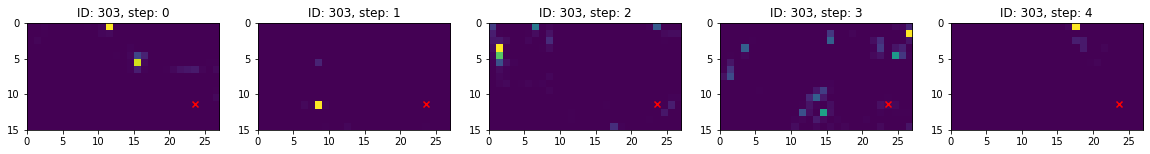

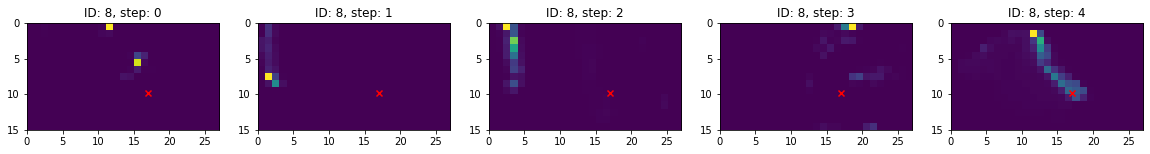

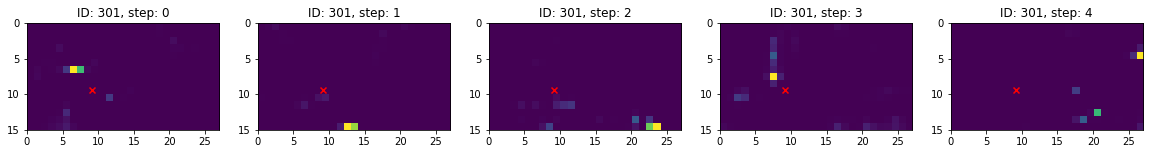

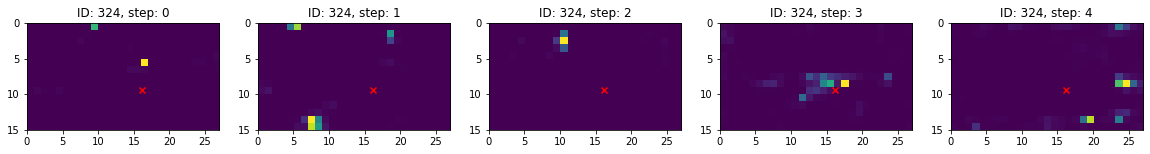

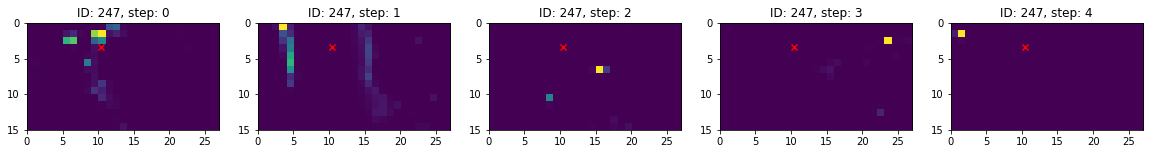

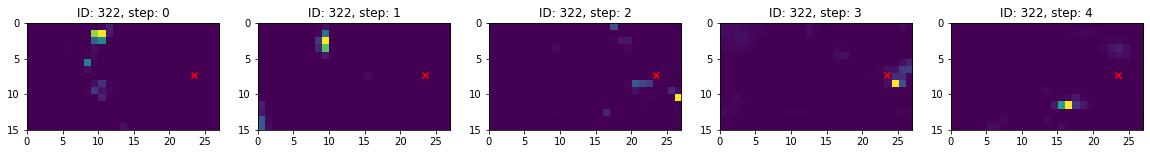

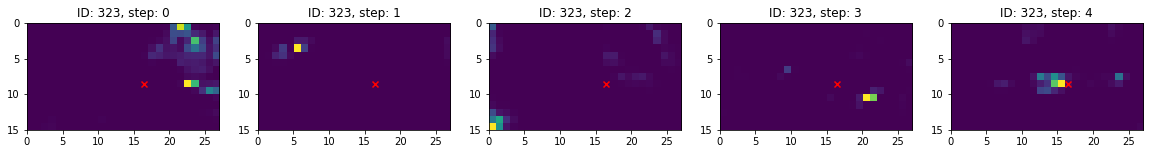

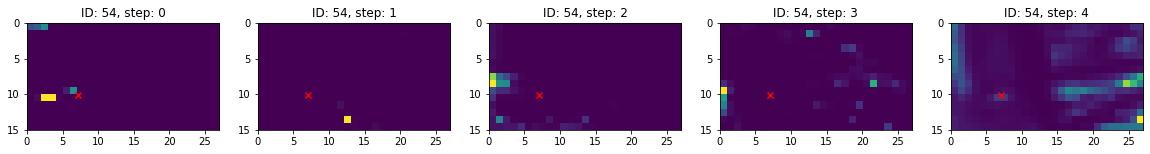

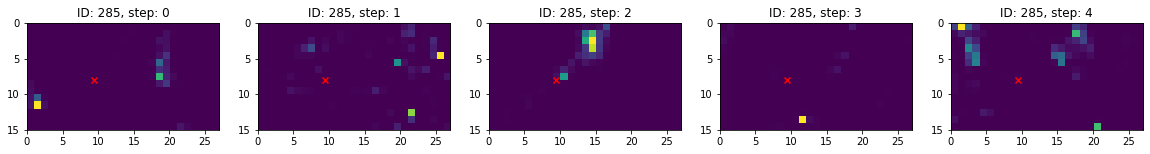

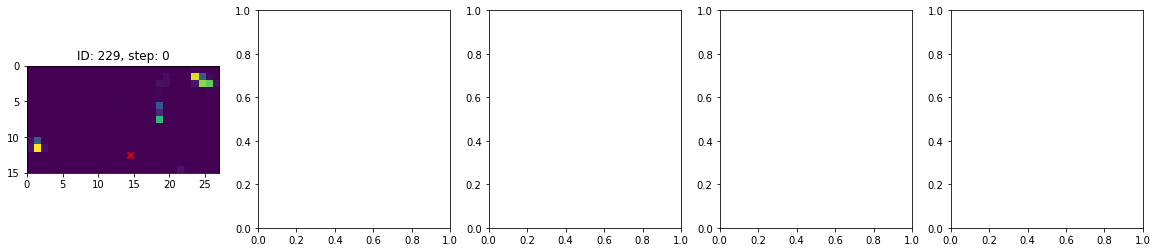

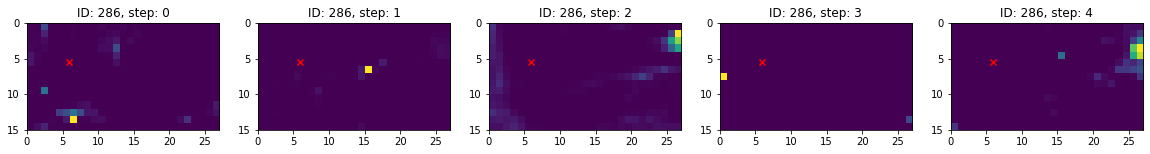

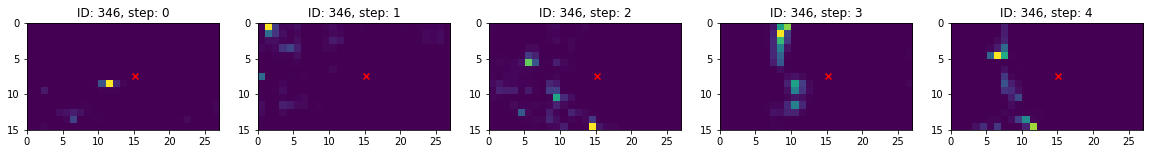

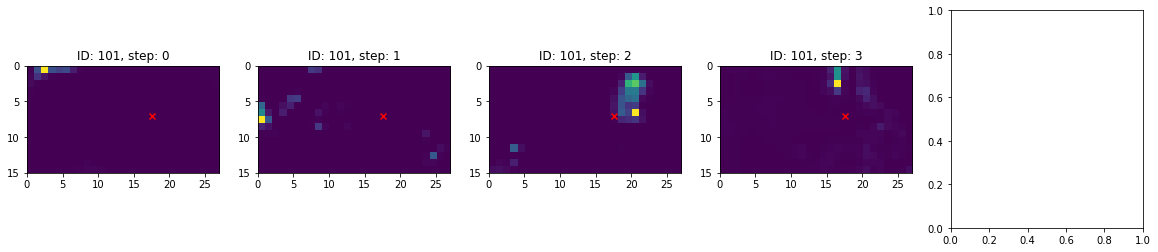

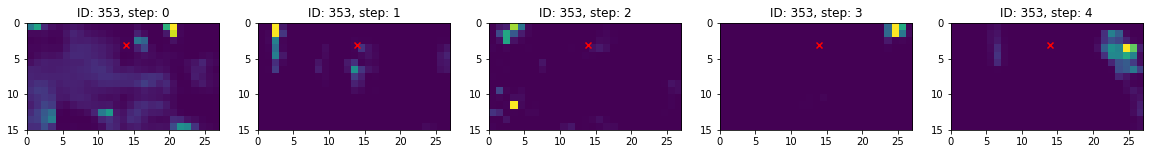

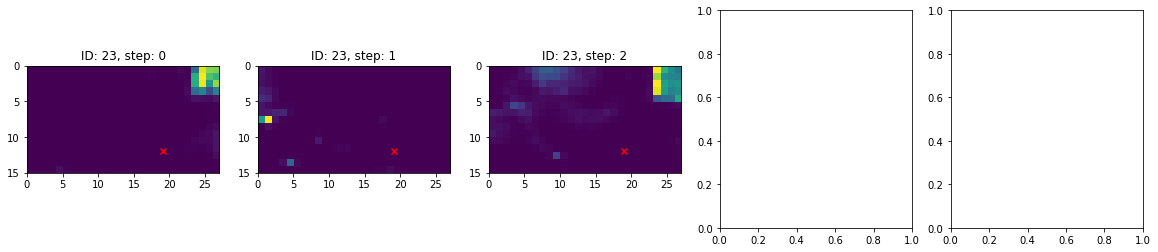

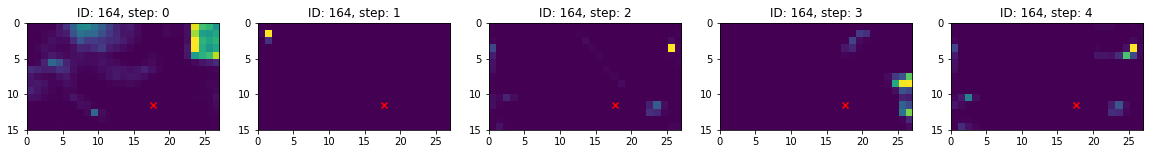

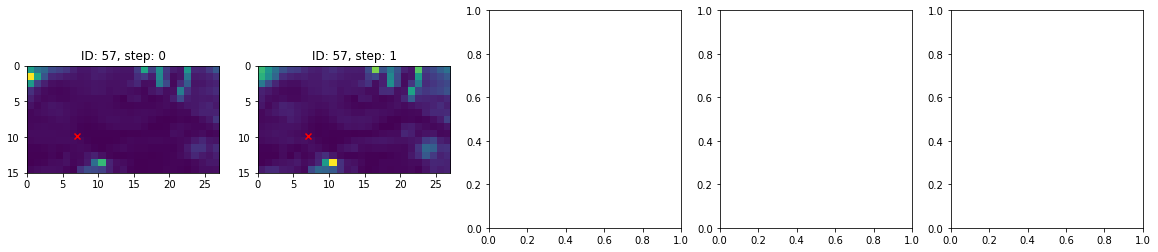

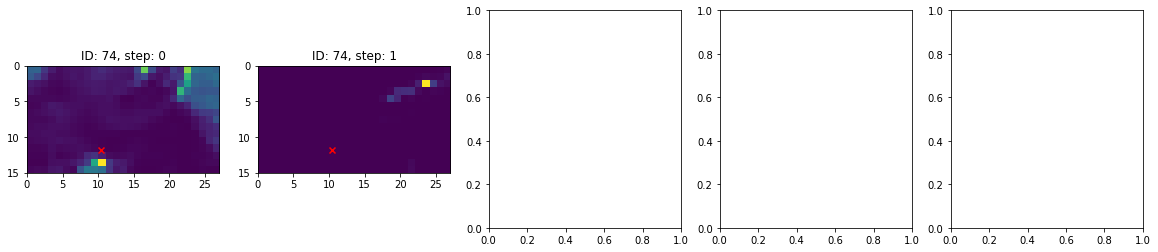

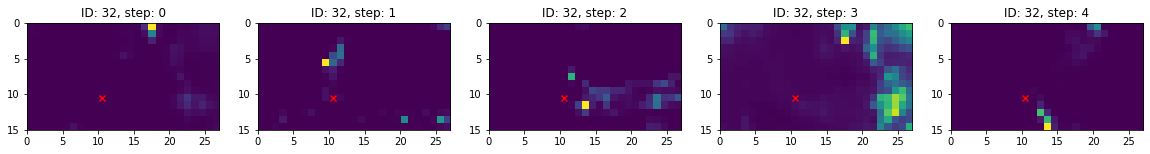

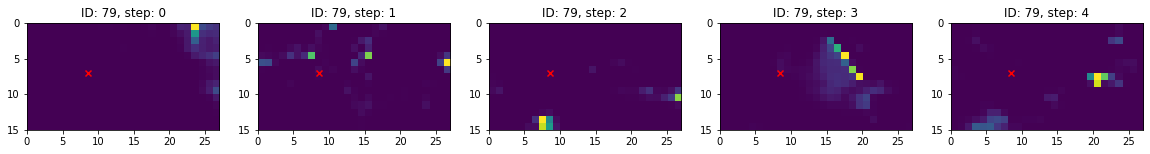

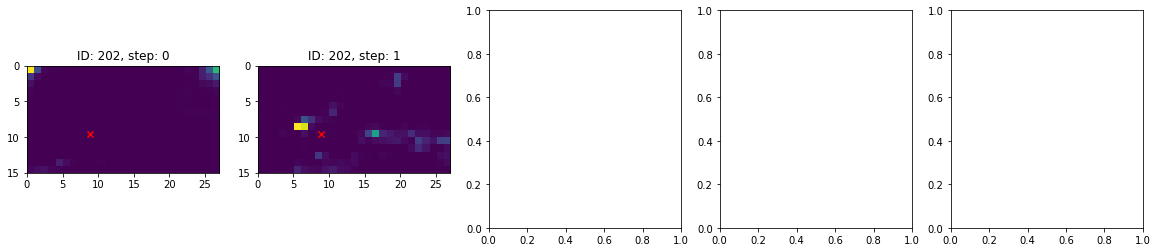

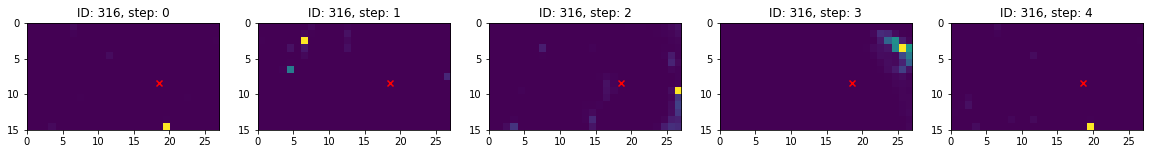

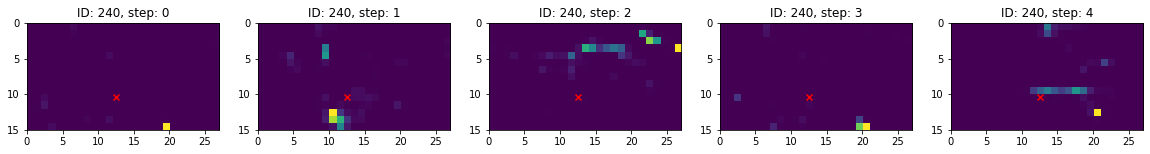

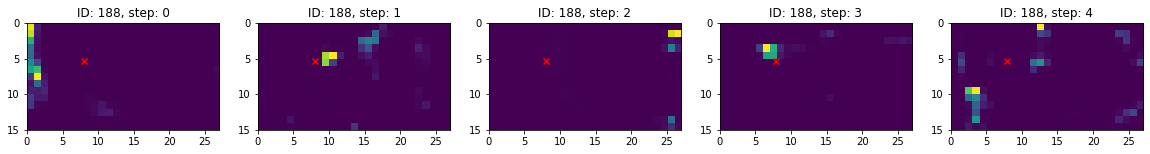

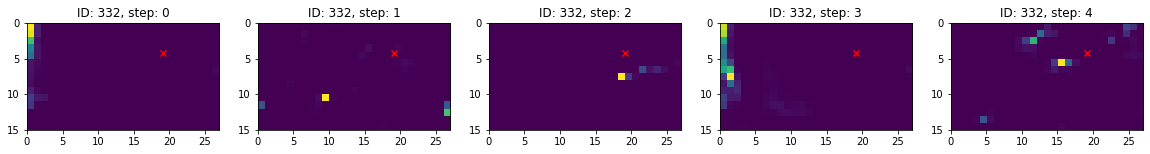

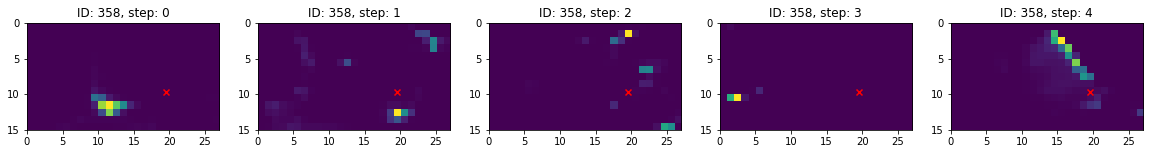

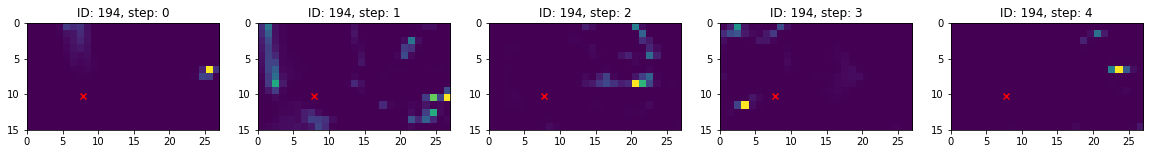

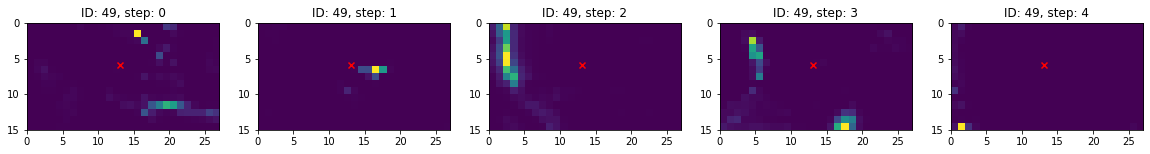

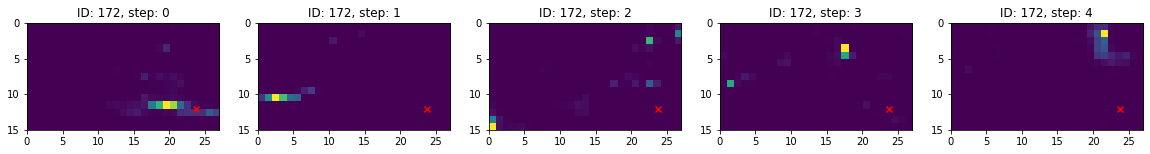

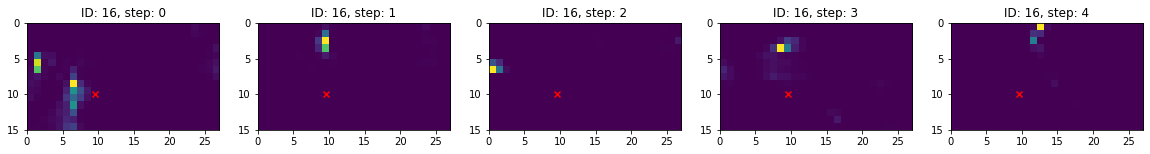

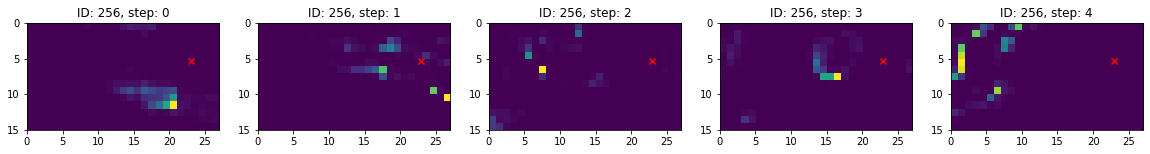

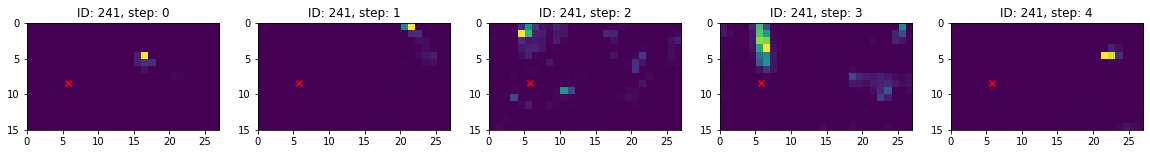

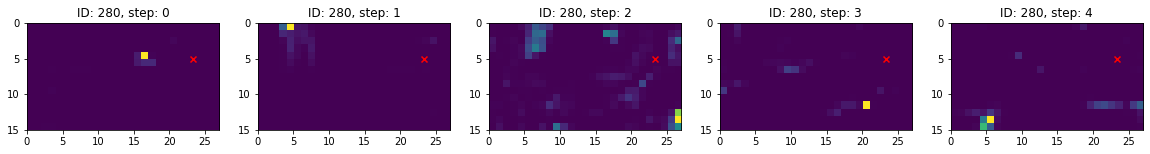

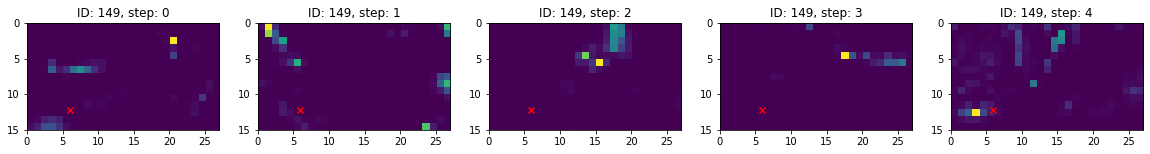

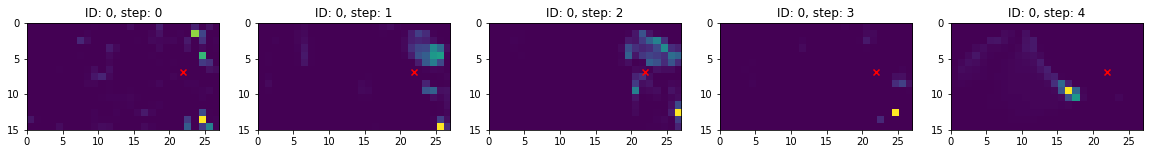

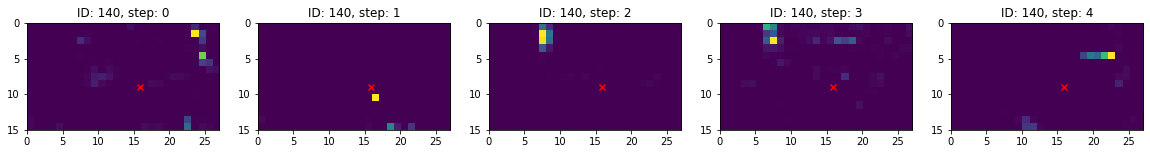

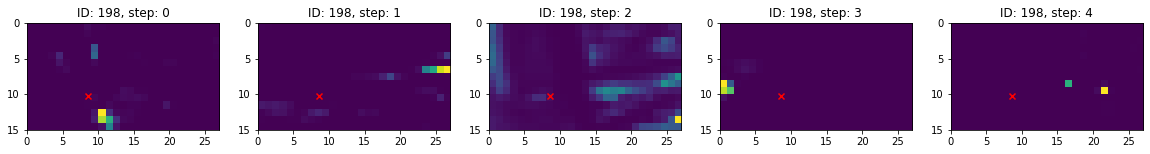

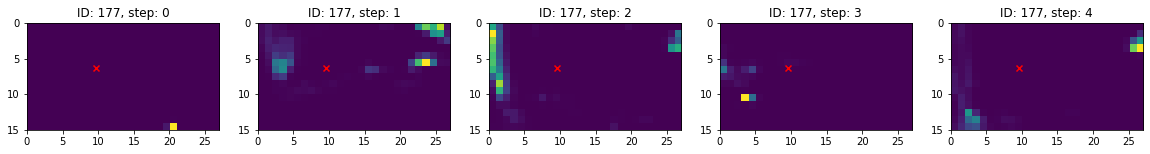

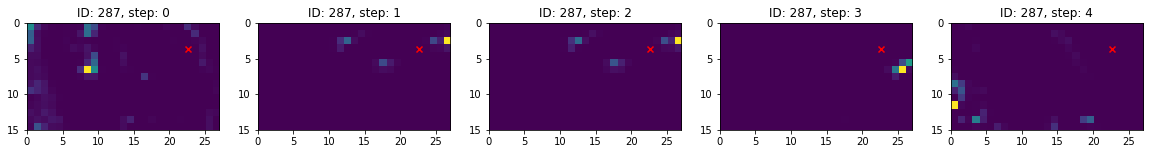

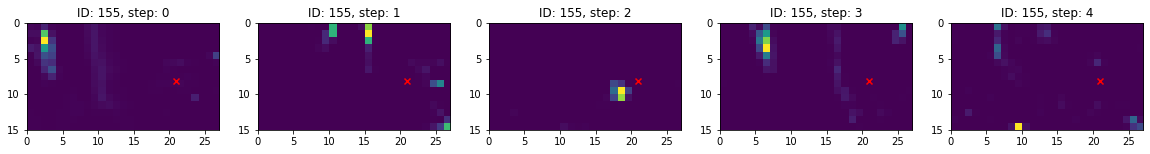

In [51]:
neuron_ids = np.array(list(att_dict.keys()))[:40] # np.arange(0, 10)
N, H, W = outpatt_matrix_H_W.shape

def plot_steps(neuron_id, centroids, att_dict):
    centroid = centroids[neuron_id - 1]
    predicted_map = reduce_layer_heads_id(att_dict, neuron_id)
    predicted_map_H_W = predicted_map.view(-1, H, W) # (Nid, H, W)
    n_steps = predicted_map.shape[0]

    # Calculate the number of rows needed for the grid
    columns = 5
    rows = 1
    # Set up the figure and axes
    fig, axes = plt.subplots(rows, columns, figsize=(4 * columns, 4 * rows))
    # Flatten the axes to make it easier to iterate through
    axes = axes.flatten()
    for steps in range(columns):
        if steps >= n_steps:
            break
        plot_map_with_centroid(axes[steps], predicted_map_H_W[steps], centroid, steps, W, H)
        # set title
        axes[steps].set_title(f"ID: {neuron_id}, step: {steps}")


for neuron_id in neuron_ids:
    plot_steps(neuron_id, centroids, att_dict)

/tmp/ipykernel_1226770/2250135288.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(rows, columns, figsize=(4 * columns, 4 * rows))


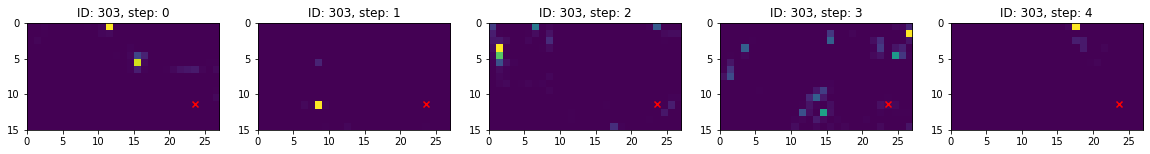

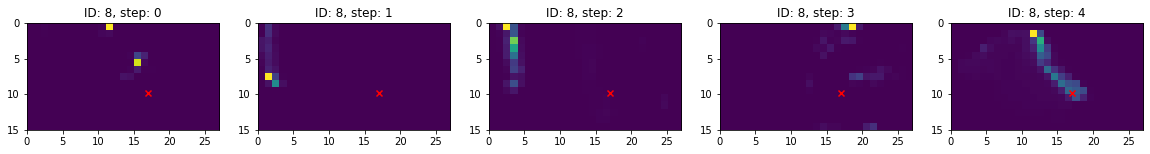

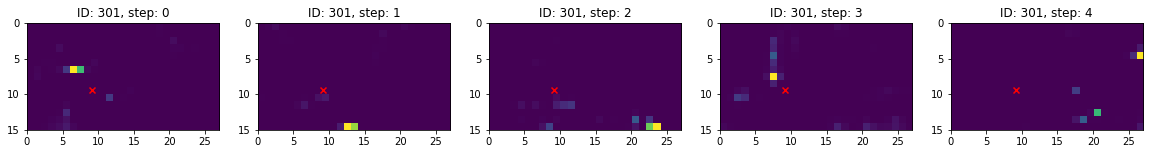

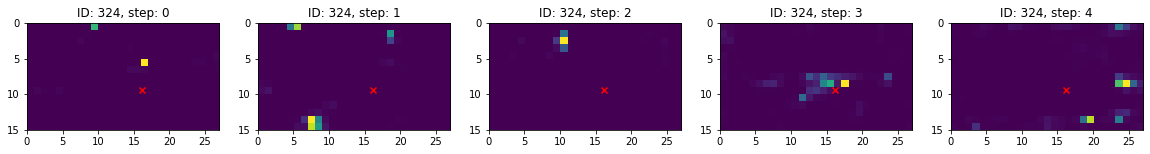

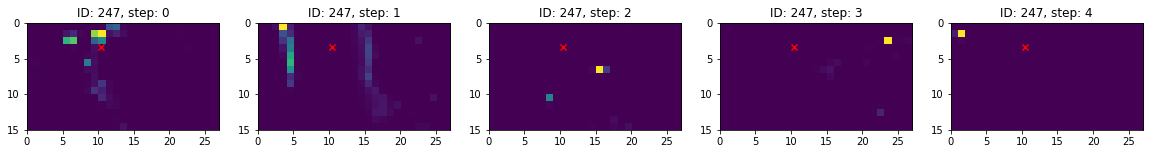

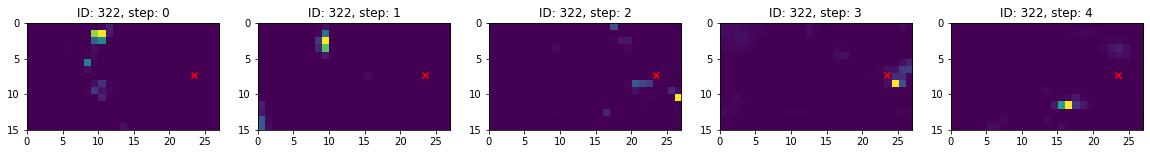

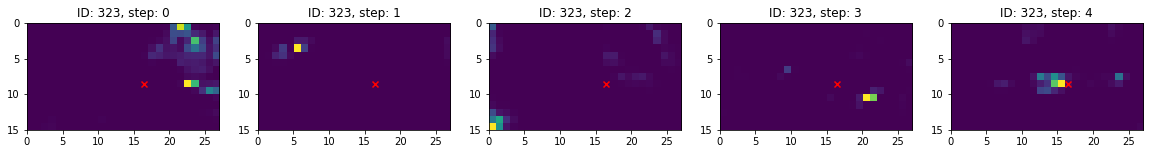

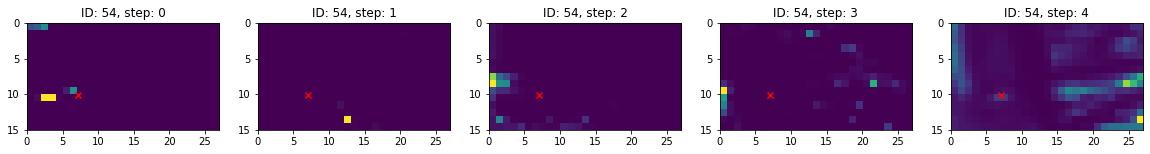

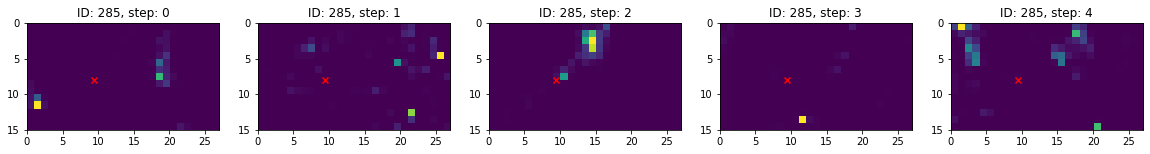

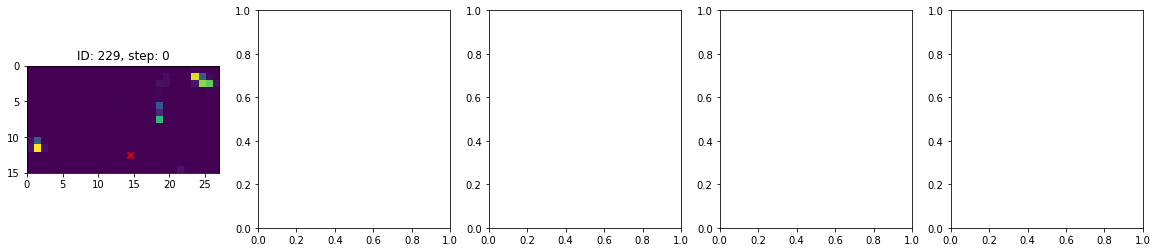

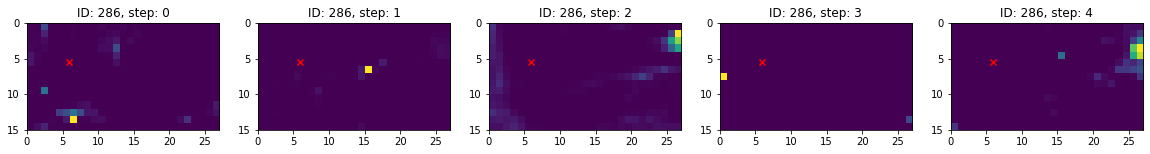

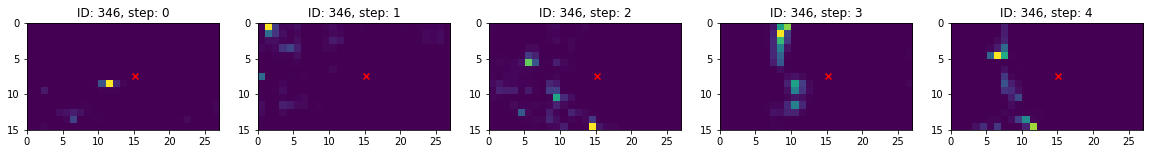

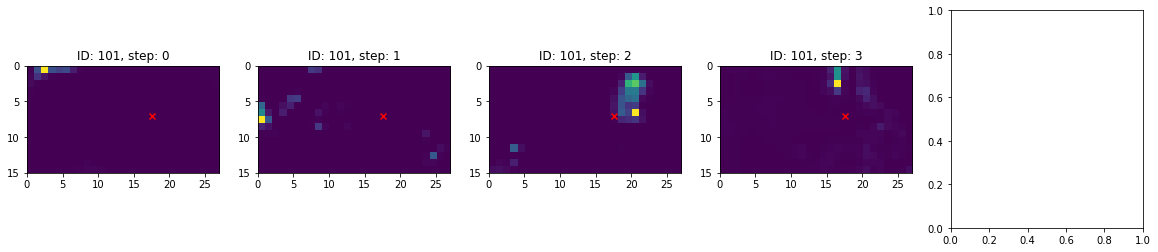

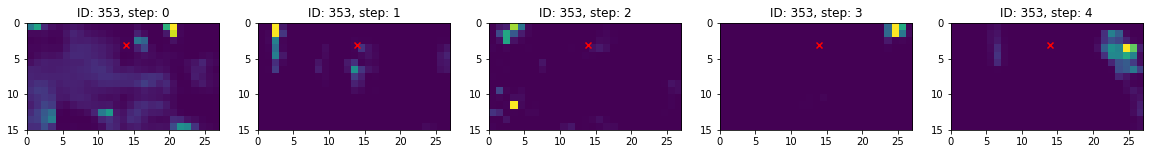

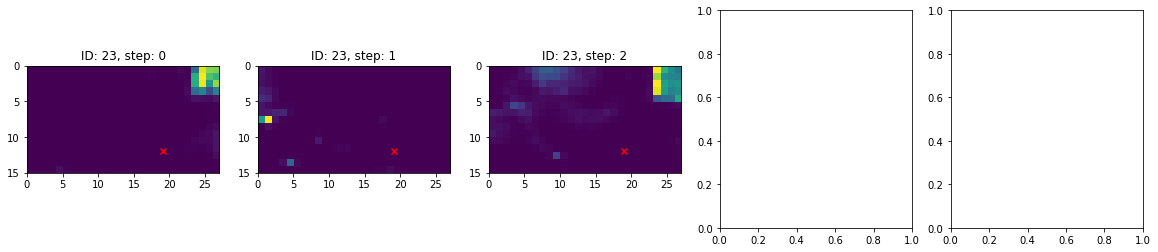

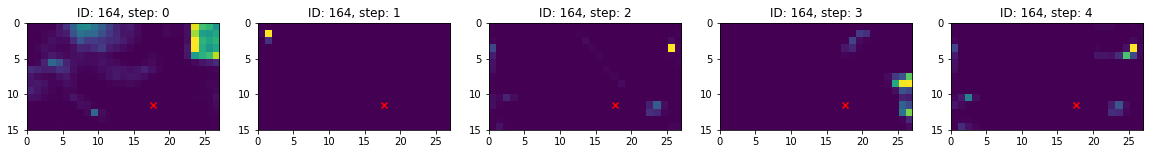

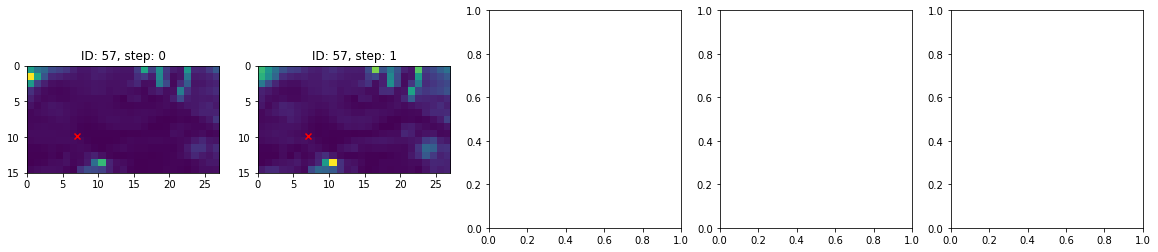

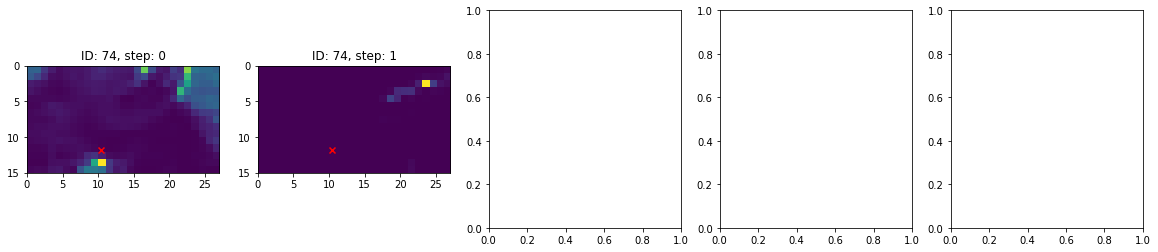

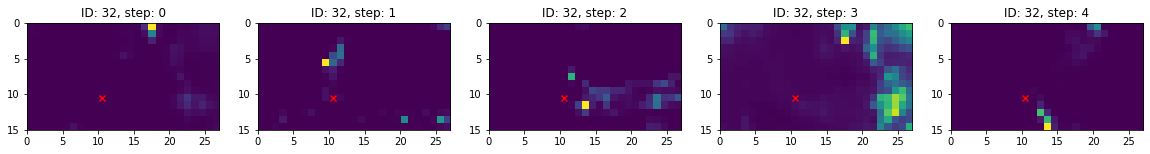

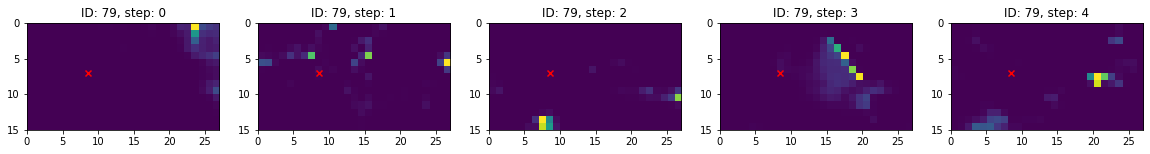

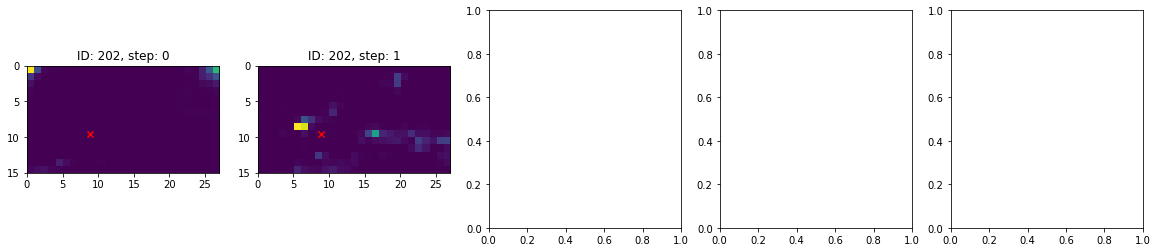

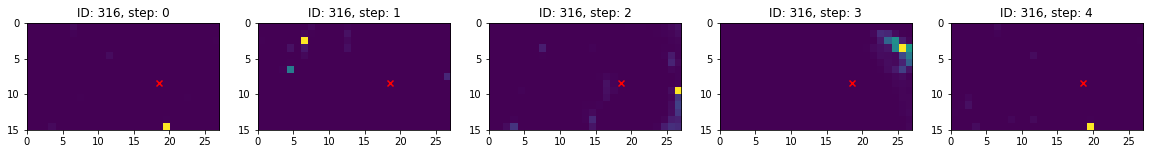

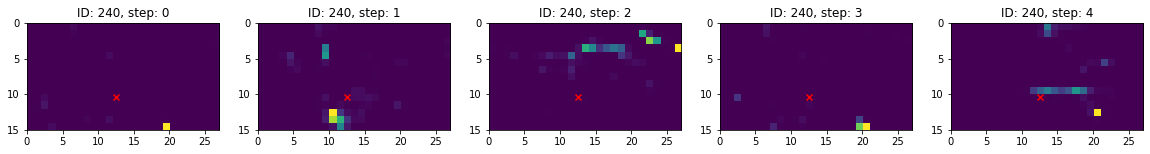

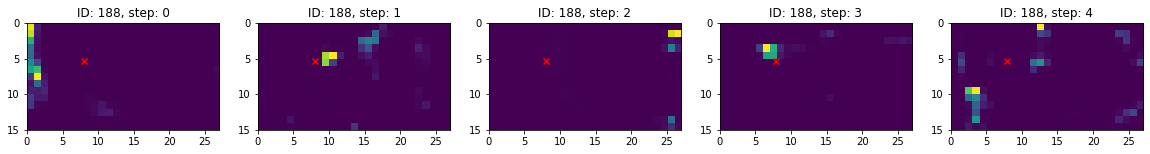

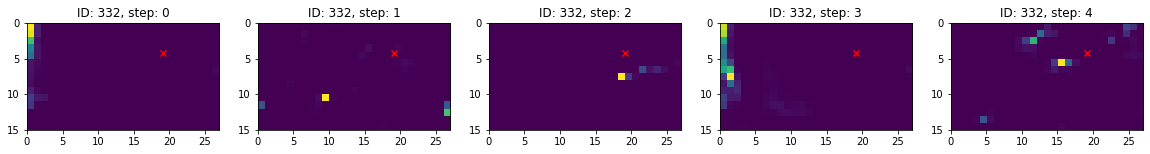

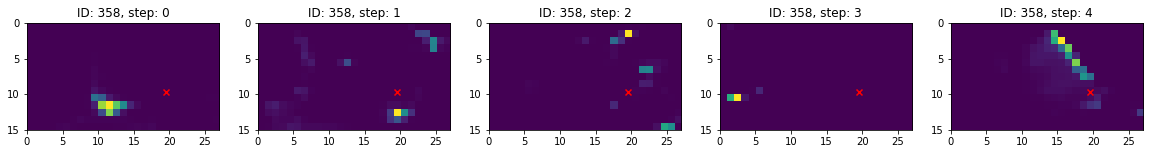

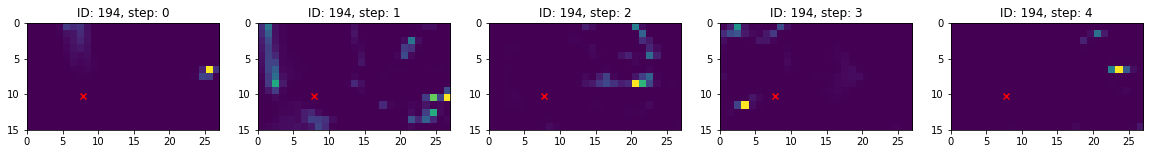

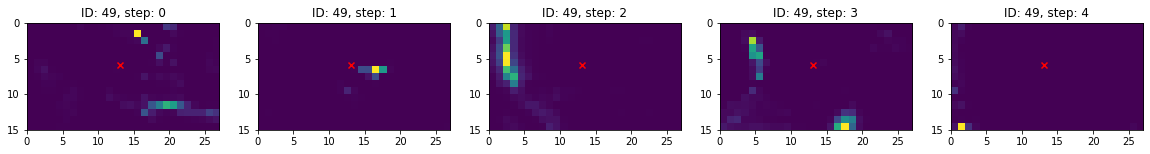

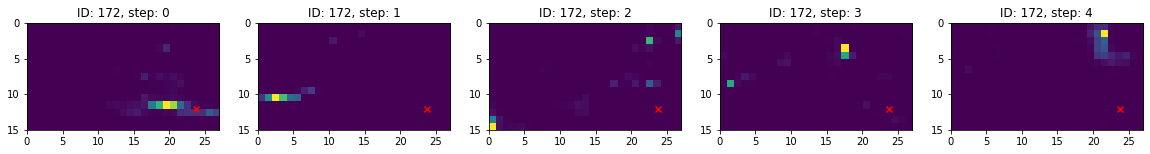

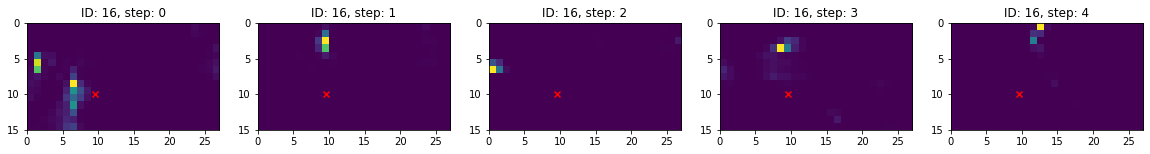

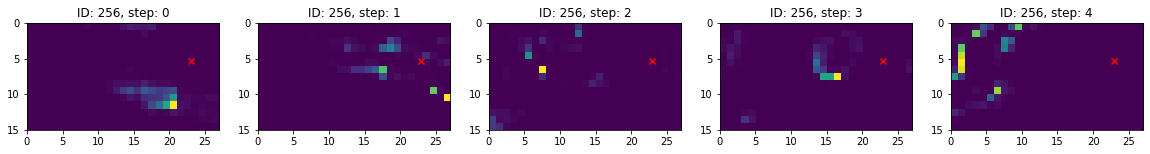

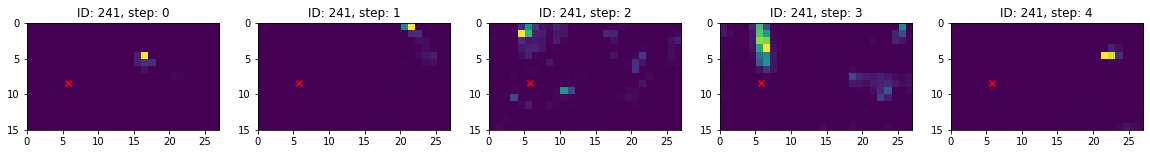

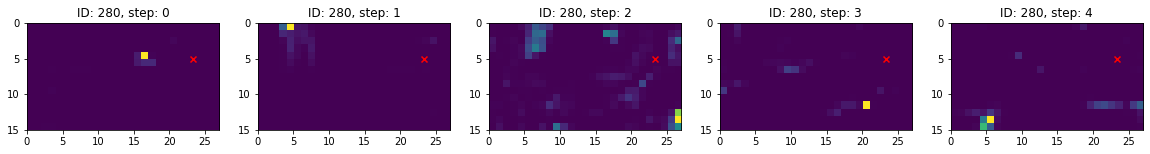

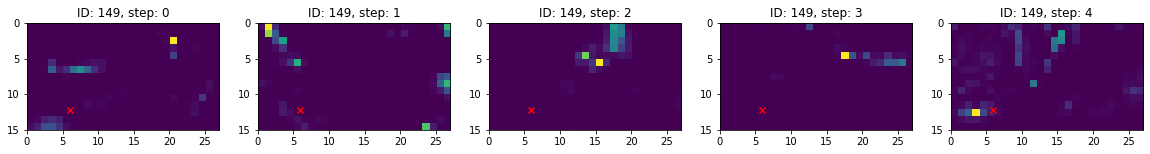

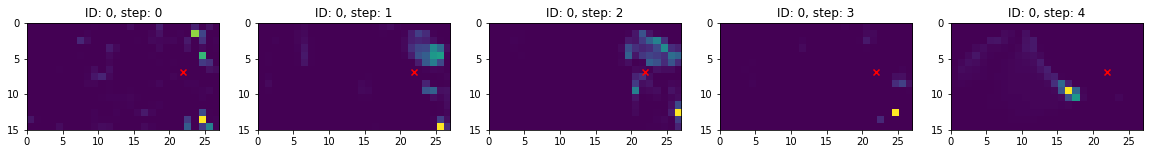

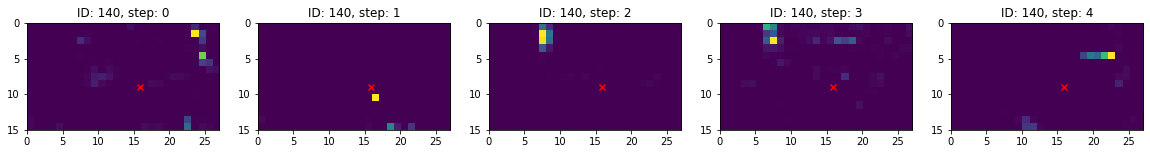

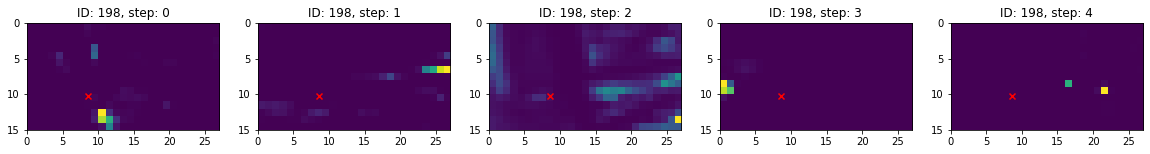

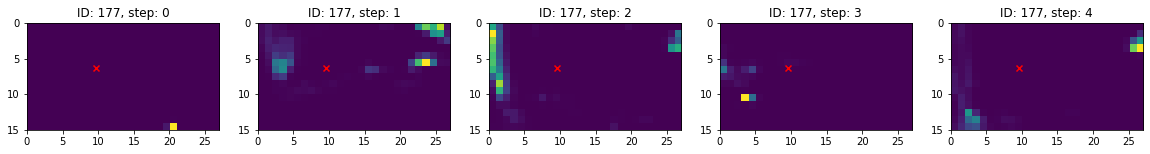

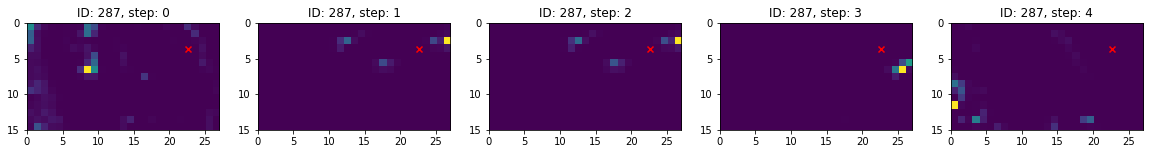

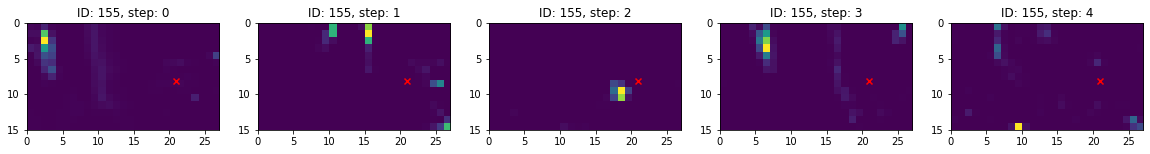

In [52]:
for neuron_id in neuron_ids:
    plot_steps(neuron_id, centroids, grad_att_dict)

In [ ]:
att_grad_matrix.shape